<div style="text-align: right">Kane Toh, 05/05/2020 </div> 

# Packages

In [317]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import numba
import seaborn as sns
sns.set(style='whitegrid', context='notebook', 
        palette='muted', rc={'axes.labelsize': 16})


import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

from math import *
from itertools import groupby
from collections import OrderedDict
import numbers

from scipy.optimize import fsolve


# Architecture of the *Cis*- regulatory function:

**Hill-equation**:

$$ \frac{dx}{dt} = (\alpha_{1} + \frac{max_{1}x^n}{a^n + x^n})(\frac{b^n}{b^n + y^n}) - \lambda_{1}x_{1} $$

$$ \frac{dy}{dt} = (\alpha_{2} + \frac{max_{2}y^n}{c^n + y^n})(\frac{d^n}{d^n + x^n}) - \lambda_{2}x_{2} $$

where:
- `x` and `y` are the concentrations of the 2 proteins X and Y.
- $\alpha_{1}$ and $\alpha_{2}$ are the rates of production of gene X/Y, in absence of activation by X/Y.
- `n` is the Hill coefficient.
- `a` and `c` are the concentrations for the half-maximal activation by genes X/Y on genes X/Y. The inverses, $\frac{1}{a}$   and $\frac{1}{c}$ represents the efficiency of the activator in other equivalent formulations (see Goutsias and Kim, 2004) 
- `b` and `d` are the concentrations for the half-maximal repression by genes X/Y on genes Y/X. The inverses, $\frac{1}{b}$
and $\frac{1}{d}$ represents the efficiency of the repressor in other equivalent formulations.
- $max_{1}$ and $max_{2}$ are the maximum rates of protein production by activators X / Y. To see this, 
  take $\displaystyle\lim_{a \to 0} \frac{max_{1}x^n}{a^n + x^n}$
 

Equation is modified from Verd et al., (2014) and Jaeger et al., (2012), with
the exact form seen in Laslo et al.,(2006) - see supplementary equation S1.
In the Verd and Jaeger formulation, the maximum rate of protein production 
set by the activator is implicitly set to 1 - this has been adjusted in the stochastic simulation
to convert concentrations (continuous) to molecule counts (discrete).

**General assumptions in Michaelis-like formulations**
1.  Extreme cooperativity. (Hill, 1985, pg 65)
2.  AND regulatory logic. 
3.  Polymerase is present in excess.
4.  Activator and repressor act at independent sites.


Set the value of alpha1 and alpha2 to zero: In the Laslo paper:
"The term e0 is included to avoid extending the network to include activators for the primary cell fate determinants"


In [2]:
 def protein_production (x, alpha1, alpha2, a, c, b, d, max1, max2, tolerance = 1e-8): 
    """Return the cis-regulatory function i.e. the protein production rate.
    
    Keyword arguments: Definition and (units)
    x      -- input numpy array of concentration of 2 gene products X and Y. (concentration)
    alpha1 -- Rate of production of gene X, in absence of activation by X. (concentration/time)
    alpha2 -- Rate of production of gene Y, in absence of activation by Y. (concentration/time)
    a      -- Concentration for half-maximal activation by gene X. (concentration)
    c      -- Concentration for half-maximal activation by gene Y.(concentration)
    b      -- Concentration for half-maximal repression by gene Y.(concentration)
    d      -- Concentration for half-maximal repression by gene Y. (concentration)
    max1   -- Maximum rate of protein production caused by activator X.(concentration/time)
    max2   -- Maximum rate of protein production caused by activator Y.(concentration/time)"""
  
    xp,yp = x[0],x[1]
    xdot = (alpha1 +  max1*(xp**4 / (a**4+xp**4 )))*(b**4/ (b**4 +yp**4))
    ydot = (alpha2 + max2*(yp**4 / (c**4+yp**4 )))*(d**4/ (d**4 + xp**4)) 
    f = np.array([xdot, ydot])
    
    for conc in f:
        if conc < tolerance:
            conc = 0
    return f

In [3]:
def decay (x, lambda1, lambda2, tolerance = 1e-8):
    """Return the decay rate.
    
    Keyword arguments:
    lambda1-- decay rate of protein product X. (concentration/time)
    lambda2-- decay rate of protein product Y. (concentration/time) """
    
    xd,yd = x[0],x[1]
    xdot = lambda1*xd
    ydot = lambda2*yd
    f = np.array([xdot, ydot])
   
    for conc in f:
        if conc < tolerance:
            conc = 0
        
    return f
    

In [5]:
def deterministic_term (protein_production, decay):
    """Return the deterministic/mean function of the chemical langevin equation (CLE).
    
    This is equivalent to the Reaction Rate Equation determined from the law of mass action in 
    classic chemical kinetics""" 
  
    xp,yp,xd,yd = protein_production[0] , protein_production[1], decay[0], decay[1]
    xdot = xp-xd
    ydot = yp-yd
    f = np.array([xdot, ydot])
    return f

In [4]:

def toggle_rhs(x, alpha1, alpha2, a, c, b, d, lambda1, lambda2):

    xdot=[0,0]

    xdot[0] = ( alpha1 + ( x[0]**4 / ( a**4+x[0]**4 ) ) )*(b**4/ ( b**4 +x[1]**4 ) ) - (lambda1*x[0]);
    
    xdot[1] = ( alpha2 + ( x[1]**4 / ( c**4+x[1]**4 ) ) )*(d**4/ ( d**4 + x[0]**4 ) ) - (lambda2*x[1]);

    f = xdot
    
    return f

# Preliminary attempts at stochastic simulations

## Background on stochastic differential equations (SDE)

A stochastic differential equation (SDE) has the form:

$ d\mathit{x} = \mathit{\mu(x,t)dt} + \mathit{\sigma(x,t)dW} $

where:

- $\mu(x,t)$ is the **drift** coefficient / **deterministic** term
- $\sigma(x,t)$ is the **diffusion** coefficient / **diffusion** term 
- `dW` is the derivative of a **Brownian Motion**. Specifically, this derivative is called **white noise**, and is a sequence of gaussian-distributed random variables.

[Interpretation](https://en.wikipedia.org/wiki/Stochastic_differential_equation#Background)
A heuristic to interpret the SDE is that, for a small interval $\delta$, the process $X_{t}$ changes by a value which is normally distributed with mean $\mu(x,t)\delta $ and variance $\sigma^{2}(x,t)\delta $. 

## Connection with GRN modelling

SDEs are relevant to modelling  GRN dynamics from the observation that gene regulation can be treated as a **continuous-time, discrete state Markov process / Markov jump process**. This treatment has two salient points:

1. Gene regulation is a discrete state stochastic process. This is in contrast to traditional approaches that model dynamical systems with ordinary differential equations, where the concentration of reacting species evolves in a continuous and discrete fashion. It is an obvious truth that molecular entities change in discrete steps and that chemical reactions are inherently probabilistic. The important question here is whether this discretisation can be replaced with the aforementioned continuous approximation. The validity of the approximation depends on the  number of molecules. For numbers significantly smaller than Avogadro's constant, a stochastic approach that takes molecular fluctuations into account becomes a more accurate description. In this scenario, fluctuations should not be simply 'averaged away' as they can lead to interesting and important behaviours that differ quantitatively and qualitatively from the deterministic approximation. Indeed, in the context of gene reguation, this is particularly relevant with the biological observation that transcription factors of multiple lineages are expressed at low levels in progenitors to prime them towards their destination fates. Intriguing phenomena that can arise when stochastic fluctuations are not trivial include stochastic focusing `(Paulsson et al., 2000)`, the erasure of a stable fixed point `(Lee and Lee, 2018)` and stochastic state switching `(Arkin et al., 1998)`.

2. The stochastic process is markovian. This is particularly attractive because of the mathematical tractability of markovian analyses and the theoretical advances in numerical simulation of markovian processes. For this reason, we will stick to the traditional markovian treatment. Recently however, there has been an increasing switch towards a non-markovian treatment and this has been examined further in `Zhang and Zhou., (2019)`.  


>A stochastic process is a collection of random variables, which we will define by the following set of $\mathit S$ - valued random variables: $ \{X_{i}(t) | t\in T, i\in \Omega, X_{i}(t)\in S\}$ where we take `T` to be time, $\Omega$ as the index set, and `S` as the state space. 
Then, a first-order Markov process is a special category of stochastic processes, where the probability of a state being attained at time $\mathit t$ depends only on the previous state, and not on the entire past history of the system. In other words, the stochastic process is **memoryless**, fulfilling the Markov property:$ P(X(t+dt) = x | {X(t) = x(t) | t \in [0,t]}) = \\ P(X(t+dt) = x | {X(t) = x(t)}), \quad \forall t \in [0,\infty] , x \in \mathit S $ 


## The Chemical Langevin Equation

The Chemical Langevin Equation (CLE) is simply an SDE, where $\mathit{\mu(x,t)dt}$ and $\mathit{\sigma(x,t)dW}$ matches the mean and standard deviation of the diffusion/langevin approximation to the birth-death process `(Pakdaman et al., 2010)`.

Essentially, we can reformulate the problem as a birth-death process with immigration rate $x_{p}$ and death rate $\delta$ and the random variable $X$ takes the state $x$ at time $t$. Then the state transition probabilities are:

$\rm P(X_{t+dt} = x-1) = x\delta \rm d \mathit t \\ P(X_{t+dt} = x+1) = x_{p} \rm d \mathit t\\ P(X_{t+dt} = x)   = 1 - x\delta \rm d \mathit t - x_{p} \rm d \mathit t$

Let $\rm d \mathit X_{t}$ be the increment of the process. Then, its
- expectation : 
$\mathbb{E}(\rm d \mathit X_{t}) = (x_{p} - x\delta)\rm d \mathit X_{t}$ 
- variance : $\mathbb{E}[(\rm d \mathit X_{t})^2] - [\mathbb{E}(\rm d \mathit X_{t})]^2$ = $(x_{p} + x\delta)\rm d \mathit X_{t}$ as $(\rm d \mathit t)^2$ term is negligibly small.

In [1333]:
# Parameters in deterministic term
alpha1 = 0.1
alpha2 = 0.1
a = 0.5 
c = 0.5
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25

# Parameters in stochastic term
#constant_noise = 0.10
dt = .001  # Time step.
T = 100  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.
omega = 1000 #Volume parameter. This parameter appears again in the Gillespie simulation to convert concentrations to molecules.
sqrtdt =  np.sqrt(dt/omega) 

## Euler-Marayama method to simulate the CLE

The numerical scheme is:

$ x_{n+1}  = x_{n} + \rm d\mathit{x} = x_{n} + \mathit{a(x,t)dt} + \mathit{b(x,t)} \sqrt{\mathit{dt}} \zeta \qquad \zeta \sim N(0,1) $


In [89]:
def euler_marayama_CLE (n_traj, x_init, y_init, tolerance, **kwargs):
# Vector containing successive values of the trajectory for both genes
n_traj = 5
x = np.zeros((n_traj,2,n))
x_init = 0.7
y_init = 0.2
# Initial condition 
x[:,:,0]= [x_init,y_init]

tolerance = 1e-8

# Euler-Marayama method
for k in range(n_traj):
    print('Iteration %d/%d finished'% (k+1, n_traj))
    for i in range(n - 1):
        pp = protein_production([x[k][0][i], x[k][1][i]],alpha1,alpha2,a,c,b,d, max1, max2)
        de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
        detT = deterministic_term(pp,de)
        stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
        x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
        x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

        # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
        if(x[k][0][i + 1] < tolerance):
            x[k][0][i + 1] = 0
        elif(x[k][1][i + 1] < tolerance):
            x[k][1][i + 1] = 0


Iteration 1/5 finished
Iteration 2/5 finished
Iteration 3/5 finished
Iteration 4/5 finished
Iteration 5/5 finished


In [ ]:
#Interpolating values
k = 10

""" Arguments for numpy.interpolate:
1) All x_vals to do interpolation on 
2) Actual x_val values that u feed into function x 
3) The function f(x)"""

x_interpolate = np.interp(np.arange(n * k), np.arange(n) * k, x[0]) 
y_interpolate = np.interp(np.arange(n * k), np.arange(n) * k, x[1])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
ax0, ax1, ax2 = axes.flatten()

ax0.plot(t,x[0])
ax0.set_title("Sample path of gene X")
ax1.plot(t,x[1])
ax1.set_title("Sample path of gene Y")
ax2.scatter(x_interpolate, y_interpolate, c = range(n * k), cmap=plt.cm.jet, linewidths=0, marker='o', s=3)
ax2.set_title("Phase portrait of X and Y with simulated trajectory")


IndexError: too many indices for array

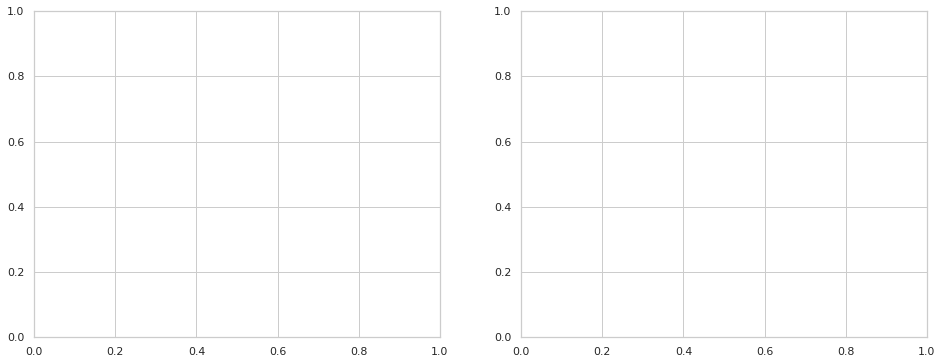

In [1332]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
ax0, ax1 = axes.flatten()

# Plot gene X trajectories
for i in range(n_traj):
    ax0.plot(t, x[i,0,:], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[i])

# Plot gene X mean
ax0.plot(t, x[:,0,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])
ax0.set_title("Sample path of gene X")

# Plot gene X trajectories
for i in range(n_traj):
    ax1.plot(t, x[i,1,:], '-', lw=0.3, alpha=0.3, 
               color=sns.color_palette()[i])

# Plot gene X mean
ax1.plot(t, x[:,1,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])
ax1.set_title("Sample path of gene Y")

## Exact realisation of the stochastic process with the Gillespie algorithm (direct method)

In [63]:

def directMethod(
    prop_fcn, update_fcn, tspan, X0, record_skip_steps=0, record_max_length=1e5
):
    # Initialise array to hold the concentration and time values, with the appropriate dimensions.
    retX = np.zeros((len(X0), int(record_max_length)), np.float64)
    retT = np.zeros(int(record_max_length), np.float64)
    
    # Initialise initial concentration and starting time  
    X = X0.flatten() 
    t = tspan[0]
    retX[:, 0] = X 
    retT[0] = t
    count = 0 #To keep track of the number of loops
    
    while (t <= tspan[-1]) & (count < record_max_length - 1):
        count += 1
        # 1) Evaluate/update the propensity function for each reaction
        a = prop_fcn(X)
        a0 = sum(a)
        
        # 2) Obtain 2 uniformly distributed random numbers
        r = np.random.rand(2)
        
        # 2.1) Obtain the time to the next reaction, tau
        tau = -np.log(r[0]) / a0
        
        # 2.2) Obtain the reaction type that fires.
        #Search sorted function: For a given ORDERED sequence of numbers, give position which the given value 
        #needs to be inserted into in order to maintain order.
        mu = np.cumsum(a).searchsorted(r[1] * a0)
        
        # Update the time and concentration vectors.
        t += tau
        X = update_fcn(X, mu)
        retT[count] = t
        retX[:, count] = X

    # In the event the loop terminates as the max time is reached, we want to truncate the arrays so we don't hold
    # all the zeros in the lists in memory.
    
    retT = retT[: count + 1]
    retX = retX[:, : count + 1]

    return retT, retX


def prop_hill(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega):
    # species
    x = X[0]
    y = X[1]
    
    # propensities
    prop = np.zeros(4)
    prop[0],prop[2] = omega * protein_production (X, alpha1, alpha2, a, c, b, d, max1, max2, tolerance = 1e-8)
    prop[1],prop[3] = decay(X, lambda1, lambda2, tolerance = 1e-8)

    return prop

def simulate_Gillespie(X0, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, t_span, n_traj, seed_no, report=True):
    # species
    x = 0
    y = 1
    n_species= 2

    # stoichiometry matrix
    stoich = np.zeros((4, n_species))
    stoich[0, x] = 1  # null -> x
    stoich[1, x] = -1  # x -> null
    stoich[2, y] = 1  # null -> y
    stoich[3, y] = -1  # y -> null
    
    # Update function: take concentration vector and update it by adding corresponding stoichometric reaction row.
    update_func = lambda X, mu: X + stoich[mu, :]

    # Initialise list to hold n_traj numbers of concentration trajectories and time steps.
    trajs_T = [[]] * n_traj
    trajs_C = [[]] * n_traj
    
    np.random.seed(seed_no)

    for i in range(n_traj):
        T, X = directMethod(
            lambda X: prop_hill(X, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega),
            update_func,
            t_span,
            X0[i],
        )
        trajs_T[i] = T
        trajs_C[i] = X
        if report:
            print("Iteration %d/%d finished." % (i + 1, n_traj), end="\r")
    return np.array(trajs_T), np.array(trajs_C)


In [66]:
n_traj = 5

para_gillespie = {
"n_traj" : n_traj,  # Number of trajectories to simulate in the simulate_gillespie function
"X0" : np.array([[x_init*omega, y_init*omega]]*n_traj),
"alpha1" : 0.1 * omega,
"alpha2" : 0.1 * omega,
"a" :0.5 * omega,
"c" : 0.5 * omega,
"b" : 0.4 * omega,
"d" : 0.4 * omega,
"max1" : 1 * omega,
"max2" : 1 * omega,
"lambda1" : 1.25 * omega,
"lambda2" : 1.25 * omega,
"omega":omega,
"t_span" : [0,5], #Total duration of gillespie simulation
"seed_no":2020,
"report" :True
}

In [67]:
trajs_T, trajs_C = simulate_Gillespie(**para_gillespie)

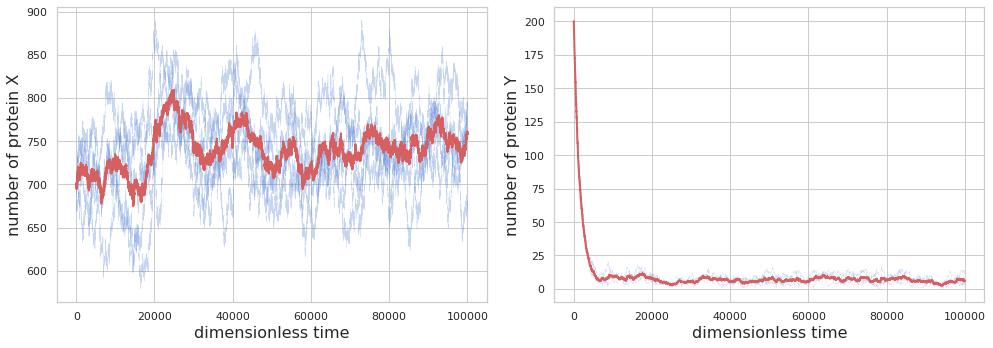

In [68]:
time_steps = np.arange(trajs_T.shape[1])

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot gene X trajectories
for i in range(n_traj):
    ax[0].plot(time_steps, trajs_C[i,0,:], '-', lw=0.3, alpha=0.3, 
               color=sns.color_palette()[0])

# Plot gene X mean
ax[0].plot(time_steps, trajs_C[:,0,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])

# Plot gene Y trajectories
for i in range(n_traj):
    ax[1].plot(time_steps, trajs_C[i,1,:], 'k-', lw=0.3, alpha=0.3,
               color=sns.color_palette()[0])

# Plot gene Y mean
ax[1].plot(time_steps, trajs_C[:,1,:].mean(axis=0), 'r-', lw=2, 
           color=sns.color_palette()[3])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of protein X')
ax[1].set_ylabel('number of protein Y')
plt.tight_layout()

## Compute steady state properties 

Consider the end of the simulation. The last 50 time points are at steady state, so we will average over them.

In [14]:
print('protein X mean copy number =', trajs_C[:,0,-1000:].mean())
print('protein Y mean copy number =', trajs_C[:,1,-1000:].mean())
print('protein X variance =', trajs_C[:,0,-1000:].std()**2)
print('protein Y variance =', trajs_C[:,1,-1000:].std()**2)
print('protein X noise =', trajs_C[:,0,-1000:].std() / trajs_C[:,0,-1000:].mean())
print('protein Y noise =', trajs_C[:,1,-1000:].std() / trajs_C[:,1,-1000:].mean())
print('protein X Fano factor =', 
      trajs_C[:,0,-50:].std()**2 / trajs_C[:,0,-1000:].mean())
print('protein Y Fano factor =', trajs_C[:,1,-1000:].std()**2 / trajs_C[:,1,-1000:].mean())


protein X mean copy number = 762.5233333333333
protein Y mean copy number = 5.4
protein X variance = 214.52545555555557
protein Y variance = 3.4146666666666667
protein X noise = 0.019208182737708173
protein Y noise = 0.34220030927653017
protein X Fano factor = 0.23538741983851866
protein Y Fano factor = 0.6323456790123456


## Compute the steady state probability distributions. 

To plot them, we plot the empirical cumulative distribution function (ECDF) from the sampling.

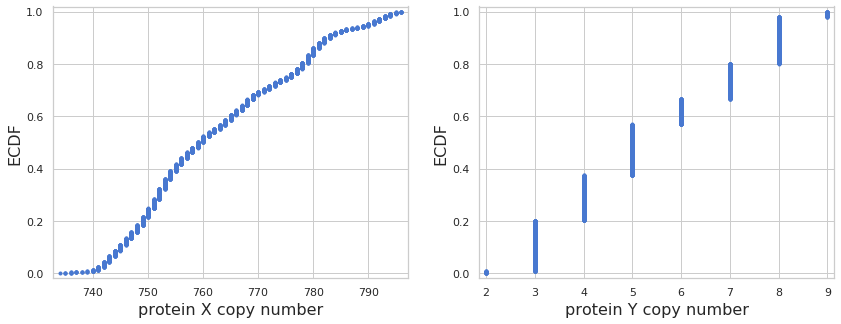

In [15]:
def ecdf(data):
    """Give x and y values for plotting ECDFs"""
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram of mRNA profile with Poisson overlayed
x, y = ecdf(trajs_C[:,0,-1000:].flatten())
ax[0].plot(x, y, '.')
ax[0].set_xlabel('protein X copy number')
ax[0].set_ylabel('ECDF')
ax[0].margins(0.02)

# Plot histogram of protein profile
ax[1].plot(*ecdf(trajs_C[:,1,-1000:].flatten()), '.')
ax[1].set_xlabel('protein Y copy number')
ax[1].set_ylabel('ECDF')
ax[1].margins(0.02)

# Bifurcation plot for deterministic system

## Obtain steady states at varying parameter values - solving dxdt = 0

In [559]:
# Parameters in deterministic term, except a and c which is updated in the loop below
alpha1 = 0.25
alpha2 = 0.25
a = c = 0.6
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25
myPara = np.linspace(0.1,1.0,num = 10000) # Values of parameters that I am changing.


In [801]:
#Set to change a and c

def steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara):
    """ Arguments to change when changing the identity of the parameter being changed:
    Line15: Set mypara[val] to the correct parameters
    Line19: Adjust the values in x_list
    Line43: Change the arguments into toggle_rhs
    """
    # Define step and grid size
    steps = 5
    highest_value = 100
    tol = 10**(-2) #10**(-8)
    steady_states_final = [] # Holds the steady states of all parameters
    steady_states = [] # Holds the steady states of current parameter value

    for val in range(len(myPara)):
        alpha1 = alpha2 = myPara[val]
        for i in range(0, highest_value, steps):
            for j in range(0, highest_value, steps):
                x=fsolve(toggle_rhs, np.array([i*0.01,j*0.01]), args = (alpha1, alpha2, a, c, b, d, lambda1, lambda2))
                x_list = np.array([alpha1, alpha2, x[0], x[1]]) #Extract the solution from fsolve
                if steady_states == []:
                    steady_states.append(x_list) # So that we have an initial reference steady state to compare against subsequently. First pass ends here.
                else:
                    for k in range (len(steady_states)):
                        ss = steady_states[k] # Holds the value of the (k+1)th steady state                        
                        if sqrt( pow( float( x_list[2] ) - float( ss[2] ), 2 ) + pow(  float( x_list[3] ) - float( ss[3] ), 2) ) < tol : #Tolerance condition to define 'similarity'
                            break #break out of this for loop entirely if the current x_list steady state matches any previous steady state.
                        
                        elif k == len(steady_states)-1: #If we reach the end of the loop, i.e. traverse the entire list of steady states
                            steady_states.append(x_list)
                           

        steady_states_final.append(steady_states)
        steady_states = []

    steady_state_tol = 10**(-10)
    x_coordinate_ss = []
    y_coordinate_ss = []

    for i in range (len(steady_states_final)):
        for j in range(len(steady_states_final[i])):
            ss = steady_states_final[i][j]
            current_steady_state = [ss[2], ss[3]]
            [dx_ss,dy_ss] =  toggle_rhs(current_steady_state,  ss[0], ss[1], a, c, b, d, lambda1, lambda2 )

            if ((abs(dx_ss) < steady_state_tol)==True) and ((abs(dy_ss) < steady_state_tol)==True):
                x_coordinate_ss.append([ss[0], ss[1], ss[2]])
                y_coordinate_ss.append([ss[0], ss[1], ss[3]])
    print(x_coordinate_ss)
    print(y_coordinate_ss)

    return [x_coordinate_ss, y_coordinate_ss]

## Evaluating the stability of the steady states - Check determinant of jacobian

In [802]:
def stability (x_coordinate_ss, y_coordinate_ss):
    """ Arguments to change when changing the identity of the parameter being changed:
    Lines9-10: Change the parameter identity being changed"""
    
    stable_steady_states = []
    unstable_steady_states = []

    for i in range(0, len(x_coordinate_ss)):
        alpha1 = x_coordinate_ss[i][0]
        alpha2 = x_coordinate_ss[i][1]
        x_ss = x_coordinate_ss[i][2]
        y_ss = y_coordinate_ss[i][2]

        f_x = ( ( 4 * (x_ss**3) * (a**4) * ( 1 / (a**4 + x_ss**4 )**2 ) ) * ( b**4 / ( b**4 +  y_ss**4 ) ) ) -lambda1

        f_y = ( alpha1 + ( x_ss**4 / (a**4 +x_ss**4 ) ) ) * ( -4 * (b**4) * ( y_ss**3) / ( b**4 +  y_ss**4)**2 )

        g_y = ( ( 4 * (y_ss**3) * (c**4) * ( 1 / ( c**4 + y_ss**4 )**2 ) ) * ( d**4 / ( d**4 + x_ss**4 ) ) ) -lambda2

        g_x = ( alpha2 + ( y_ss**4 / (c**4 + y_ss**4 ) ) ) * ( -4 * (d**4) * (x_ss**3) / ( d**4 + x_ss**4)**2 )

        det = (f_x * g_y) - (f_y * g_x)

        if det < 0:
            unstable_ss_coord = [x_coordinate_ss[i], y_coordinate_ss[i]] #unstable
            unstable_steady_states.append(unstable_ss_coord)
        else:
            stable_ss_coord = [x_coordinate_ss[i], y_coordinate_ss[i]] #unstable
            stable_steady_states.append(stable_ss_coord)
    
    print("mystable", stable_steady_states)
    print("unstable", unstable_steady_states)
    
    return [stable_steady_states, unstable_steady_states]


In [562]:
x_coordinate_ss, y_coordinate_ss = steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara)
stable_steady_states, unstable_steady_states = stability (x_coordinate_ss, y_coordinate_ss)


/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [714]:
unstable_steady_states

[[[0.3, 0.3, 0.06960737634492008], [0.3, 0.3, 0.5004390080444995]],
 [[0.3, 0.3, 0.5004390080357454], [0.3, 0.3, 0.06960737634926924]],
 [[0.6, 0.6, 0.35252047649366197], [0.6, 0.6, 0.3525204764936625]],
 [[0.8, 0.8, 0.3941175149403903], [0.8, 0.8, 0.39411751494038666]]]

## (Plot) Bifurcation diagram of deterministic system

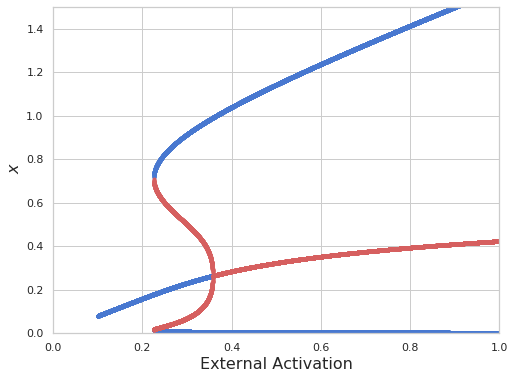

In [566]:
fig, axis = plt.subplots(1,1, figsize = (8,6))

x_vals_stable = np.array(stable_steady_states)[:,0,0]
x_vals_unstable = np.array(unstable_steady_states)[:,0,0]
genex_vals_stable = np.array(stable_steady_states)[:,0,2]
genex_vals_unstable = np.array(unstable_steady_states)[:,0,2]

axis.plot(x_vals_stable,genex_vals_stable, '.b')
axis.plot(x_vals_unstable,genex_vals_unstable, '.r')

plt.axis([0, 1, 0, 1.5])
plt.xlabel('External Activation');
plt.ylabel('$\ x$')
fig.savefig('plots_stochastic/1_det_bifurcation_ext_act.png', bbox_inches='tight')


## Sample deterministic trajectories at each parameter value

In [810]:
# Parameters in deterministic term, except a and c which is updated in the loop below
alpha1 = 0.25
alpha2 = 0.25
a = c = 0.6
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25

myPara = [0.2, 0.3, 0.6, 1.0]

In [811]:
grid_range = np.linspace(0,1.5, num =15)
dt = 0.1
num_paths = len(grid_range)**2
num_timesteps = 1000


In [812]:
x_coordinate_ss, y_coordinate_ss = steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara)
stable_steady_states, unstable_steady_states = stability (x_coordinate_ss, y_coordinate_ss)

[[0.2, 0.2, 0.15993099862909013], [0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.06960737634492008], [0.3, 0.3, 0.00844547880010768], [0.3, 0.3, 0.5004390080357454], [0.3, 0.3, 0.9153079897086465], [0.6, 0.6, 0.35252047649366197], [0.6, 0.6, 0.0051715507870040344], [0.6, 0.6, 1.238194802756356], [1.0, 1.0, 0.42406404779850343], [1.0, 1.0, 0.003241176792250203], [1.0, 1.0, 1.5838572310319683]]
[[0.2, 0.2, 0.15993099862909013], [0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.5004390080444995], [0.3, 0.3, 0.915307989709301], [0.3, 0.3, 0.06960737634926924], [0.3, 0.3, 0.008445478800169576], [0.6, 0.6, 0.3525204764936625], [0.6, 0.6, 1.2381948027564433], [0.6, 0.6, 0.005171550787033244], [1.0, 1.0, 0.42406404779850665], [1.0, 1.0, 1.5838572310301315], [1.0, 1.0, 0.003241176791036259]]
mystable [[[0.2, 0.2, 0.15993099862909013], [0.2, 0.2, 0.15993099862909013]], [[0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.23139919276986715]], [[0.3, 0.3, 0.00844547880010768], [0.3, 0.3, 0.915307989709301]],

/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [813]:
grouped_stable_ss = [[] for i in range(len(myPara))]
grouped_unstable_ss = [[] for i in range(len(myPara))]

counter = 0
for key, group in groupby(stable_steady_states, lambda x: x[0][0]):
    for thing in group:
        grouped_stable_ss[counter].append(thing)
    counter+=1
grouped_stable_ss = np.array([np.array(xi) for xi in grouped_stable_ss])

counter = 0
for key, group in groupby(unstable_steady_states, lambda x: x[0][0]):
    for thing in group:
        grouped_unstable_ss[counter].append(thing)
    counter+=1
grouped_unstable_ss = np.array([np.array(xi) for xi in grouped_unstable_ss])


In [814]:
ss_colors = ['#38b6ff', '#ff9400', '#99dd44'] # Since we have a maximum of 3 attractors (stable ss)
ss_unstable_colors = ['#ed1c24', '#fe6dbc', '#fca085'] 
path_colors = [[] for i in range(len(myPara))]

In [815]:
""" Line21: When changing the identity of the parameters, remember to change the argument in the toggle_rhs function """

import copy
num_para = len(myPara)
paths = np.zeros((num_para, num_paths, num_timesteps, 2))
tol = 10**(-2)

for h in range(num_para):
    path_counter = 0
    x_ss_stable = grouped_stable_ss[h][:,0][:,2]
    y_ss_stable = grouped_stable_ss[h][:,1][:,2]
    for i in grid_range:
        for j in grid_range:
            path_counter += 1
            xp = i
            yp = j
            paths[h, path_counter-1, 0, 0] = xp
            paths[h, path_counter-1, 0, 1] = yp
            for k in range(1, num_timesteps):
                current_coordinate = [xp,yp]
                [dxdt,dydt] = toggle_rhs(current_coordinate, myPara[h], myPara[h], a, c, b, d, lambda1, lambda2)
                dx = dxdt * dt
                dy = dydt * dt
                xp += dx
                yp += dy  
                paths[h, path_counter-1, k, 0] = xp
                paths[h, path_counter-1, k, 1] = yp
            for ss_index in range(len(x_ss_stable)):
                ss_coordinates = [x_ss_stable[ss_index], y_ss_stable[ss_index]]
                if np.sqrt((xp-ss_coordinates[0])**2 + (yp-ss_coordinates[1])**2) < tol:
                    path_colors[h].append(ss_colors[ss_index]) 
                    break
                elif ss_index == (len(x_ss_stable) - 1) :
                    unstable_index = np.array([x for x in range(len(grouped_unstable_ss)) if grouped_unstable_ss[x].any() and myPara[h] == grouped_unstable_ss[x][:,0][:,1][0]])
                    if unstable_index.size>0: 
                        x_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,0][:,2]
                        y_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,1][:,2]
                        for ss_index in range(len(x_ss_unstable)):
                            ss_coordinates = [x_ss_unstable[ss_index], y_ss_unstable[ss_index]]
                            if np.sqrt((xp-ss_coordinates[0])**2 + (yp-ss_coordinates[1])**2) < tol:
                                path_colors[h].append(ss_unstable_colors[ss_index]) 
                                break
                    else:
                        break 




In [817]:
myPara

[0.2, 0.3, 0.6, 1.0]

In [818]:
paths.shape

(4, 225, 1000, 2)

### (Plot) Deterministic phase portrait for 4 parameter values across 3 dynamical regimes

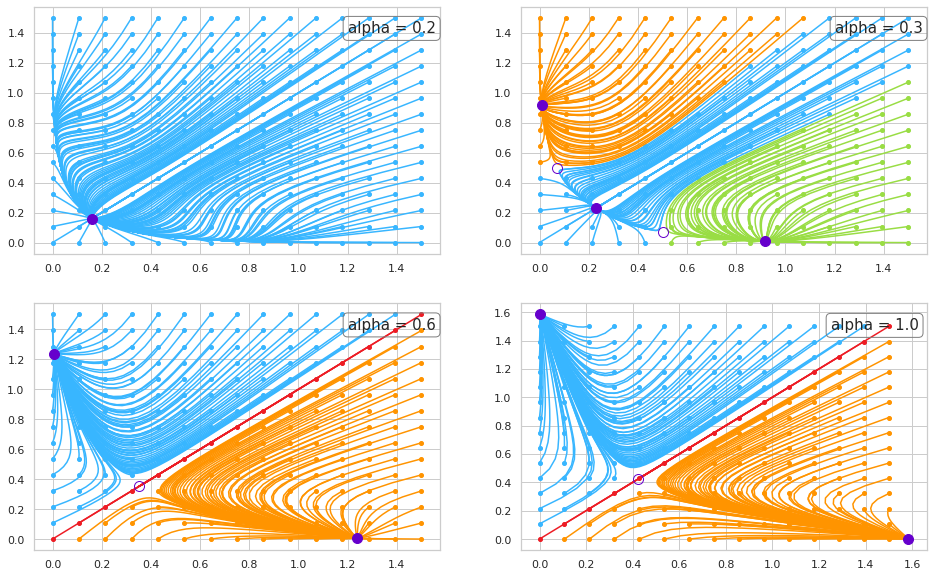

In [819]:
fig , axes = plt.subplots(2,2, figsize = (16,10))
ax = axes.flatten()

for i in range(num_para):
    for j in range(num_paths):
        ax[i].plot(paths[i,j,:,0], paths[i,j,:,1], color=path_colors[i][j])
        ax[i].plot(paths[i,j,0,0], paths[i,j,0,1], marker = '.', color=path_colors[i][j],  markersize=8)
        
    ax[i].plot(grouped_stable_ss[i][:,0][:,2], grouped_stable_ss[i][:,1][:,2], '.', color = "#6600cc",  markersize= 20)
    unstable_index = np.array([x for x in range(len(grouped_unstable_ss)) if grouped_unstable_ss[x].any() and myPara[i] == grouped_unstable_ss[x][:,0][:,1][0]])
    if unstable_index.size>0: 
        x_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,0][:,2]
        y_ss_unstable = grouped_unstable_ss[unstable_index[0]][:,1][:,2]
        for ss_index in range(len(x_ss_unstable)):
            ax[i].plot(x_ss_unstable[ss_index], y_ss_unstable[ss_index], '.', color = "#6600cc", mfc='none', markersize= 20 )

ax[0].annotate('alpha = 0.2', xy=(1.2, 1.4), xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), size = 15)
ax[1].annotate('alpha = 0.3', xy=(1.2, 1.4), xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), size = 15)
ax[2].annotate('alpha = 0.6', xy=(1.2, 1.4), xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), size = 15)
ax[3].annotate('alpha = 1.0', xy=(1.25, 1.475), xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), size = 15)

#fig.savefig('plots_stochastic/1_det_phasePortraits_ext_act.png', bbox_inches='tight')


# Experiment 1: NMps are 'stuck' in a competent state
Biological scenario:
Cells are kept in the tailbud for a prolonged period of time in a competent state

Model interpretation:
Fix parameters within tristable regime (a/c)  perhaps with stochastic fluc to represent cells moving around in region. 

Features extracted:

1. Do we see a great variance of expression levels of both genes (relative to low or higher levels of parameter values?)
Obtain numerically by CLE of 10000 trajectories, and calculating variance of each gene and their difference at specified intervals.
Methods to recover probability distribution?

2. Proportion of cells entering each attractor?

3. How long, on average, for a cell to enter an attractor? MFPT.

4. Do cells switch between attractors? Count number of times go from high to low or vice versa.


## Defining parameters for experiment

In [885]:
# Define parameters in dictionary format

stochtoggle_para = {
"alpha1" : 0.3,
"alpha2" : 0.3,
"a" : 0.6 ,
"c" : 0.6,
"b" : 0.4,
"d" : 0.4,
"max1" : 1,
"max2" : 1,
"lambda1" : 1.25,
"lambda2" : 1.25,
"omega" : 50
}

em_para = { "dt" : .001,  # Time step.
"T" : 100,  # Total time.
"n_traj" : 100,
"x_init" : 0.6,
"y_init" : 0.6,
"tolerance": 1e-8
}


In [1337]:
# Parameters for EM simulation
alpha1 = 0.3
alpha2 = 0.3
a = 0.6 
c = 0.6
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25
omega = 50

dt = .001  # Time step.
T = 100  # Total time.
n_traj = 100
x_init = 0.6
y_init = 0.6
tolerance = 1e-8

#Additional parameter for stability analyses:
myPara = [0.3]

#For plotting
t = np.linspace(0., T, n)  # Vector of times.

## EM to obtain trajectories (100 used)

In [924]:
def euler_marayama_CLE (n_traj, x_init, y_init, tolerance, dt , T, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, seed = 20):
    np.random.seed(seed)
    n = int(T / dt)
    t = np.linspace(0., T, n)
    sqrtdt =  np.sqrt(dt/omega) 
    x = np.zeros((n_traj,2,n))
    x[:,:,0]= [x_init,y_init]
    
    # Euler-Marayama method
    for k in range(n_traj):
        for i in range(n - 1):
            pp = protein_production([x[k][0][i], x[k][1][i]],alpha1,alpha2,a,c,b,d, max1, max2)
            de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
            detT = deterministic_term(pp,de)
            stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
            x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
            x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

            # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
            if(x[k][0][i + 1] < tolerance):
                x[k][0][i + 1] = 0
            elif(x[k][1][i + 1] < tolerance):
                x[k][1][i + 1] = 0
    return x

In [925]:
em_traj = euler_marayama_CLE(n_traj, x_init, y_init, tolerance, dt , T, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, seed = 20)
#euler_marayama_CLE(**stochtoggle_para, **em_para)
#1000 trajectories tkae about 20 minutes.
#np.save('traj_1000_0.6_0.6.npy', x) # save
#x = np.load('data.npy') # load

Text(0.5, 1.0, 'Sample path of gene Y')

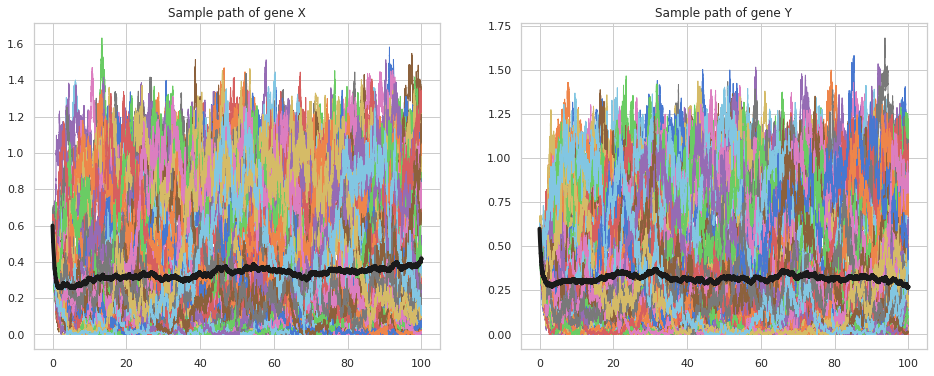

In [1338]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
ax0, ax1 = axes.flatten()

for i in range(n_traj):
    ax0.plot(t,em_traj[i][0][:], lw=1)
    ax1.plot(t,em_traj[i][1][:], lw=1)
ax0.plot(t, em_traj[:,0,:].mean(axis=0), '-', lw=4, 
           color="k")
ax1.plot(t, em_traj[:,1,:].mean(axis=0), '-', lw=4, 
           color="k")
ax0.set_title("Sample path of gene X")
ax1.set_title("Sample path of gene Y")

#ax2.scatter(x_interpolate, y_interpolate, c = range(n * k), cmap=plt.cm.jet, linewidths=0, marker='o', s=3)
#ax2.set_title("Phase portrait of X and Y with simulated trajectory")


## Obtaining steady states

In [927]:
x_coordinate_ss, y_coordinate_ss = steady_states (alpha1, alpha2, a, c, b, d, lambda1, lambda2, myPara)
stable_steady_states, unstable_steady_states = stability (x_coordinate_ss, y_coordinate_ss)

[[0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.06960737634492008], [0.3, 0.3, 0.00844547880010768], [0.3, 0.3, 0.5004390080357454], [0.3, 0.3, 0.9153079897086465]]
[[0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.5004390080444995], [0.3, 0.3, 0.915307989709301], [0.3, 0.3, 0.06960737634926924], [0.3, 0.3, 0.008445478800169576]]
mystable [[[0.3, 0.3, 0.23139919276986715], [0.3, 0.3, 0.23139919276986715]], [[0.3, 0.3, 0.00844547880010768], [0.3, 0.3, 0.915307989709301]], [[0.3, 0.3, 0.9153079897086465], [0.3, 0.3, 0.008445478800169576]]]
unstable [[[0.3, 0.3, 0.06960737634492008], [0.3, 0.3, 0.5004390080444995]], [[0.3, 0.3, 0.5004390080357454], [0.3, 0.3, 0.06960737634926924]]]


## Attractor statistics

### First passage time

In [928]:
def first_passage_time (traj_matrix, T, n, dist_x, dist_y, attractors_coord):
    """Return the first passage times of trajectories.
    
    Keyword arguments: Definition 
    traj_matrix -- trajectory array with dimensions (n_trajs, 2, n), where n_trajs is the
    number of computed trajectories and n is the number of timepoints. This is the output of the 
    euler_marayama_CLE function.
    T           -- total simulation duration
    n           -- number of time subintervals 
    dist_x      -- distance threshold for gene X to consider as having entered the steady state. 
    dist_y      -- distance threshold for gene Y to consider as having entered the steady state
    attractors_coord -- array with the coordinates of the stable steady states of interest. The """
    
    # We calculate the empirical first passage time using two methods: 
    # The next method returns the first (hence first passage) paired coordinates that match the euclidean distance condition. This is the first passage index.
    # np.nonzero returns the index of the first passage time coordinates as this is when the condition is True. This index is the time. Therefore, we have the first passage time.

    first_passage_time = np.zeros((traj_matrix.shape[0], len(attractors_coord)))
    for traj in range(traj_matrix.shape[0]):
        paired_coord = np.array(list(zip(traj_matrix[traj,0,:], traj_matrix[traj,1,:]))) 
        for index in range(len(attractors_coord)):
            fp_coord = next((x for x in paired_coord if (np.linalg.norm(x[0]- attractors_coord[index][0][2])) < dist_x and (np.linalg.norm(x[1]- attractors_coord[index][1][2])) < dist_y), -1)
            if not isinstance(fp_coord, int): #If there's no passage into the attractor, the next method returns the default int -1. 
                fp_time, _ = np.nonzero(paired_coord == fp_coord)
                first_passage_time[traj][index] = fp_time[0]/n * T #Converting the time index into simulation time
    return first_passage_time

In [929]:
fpt = first_passage_time (em_traj, 1000, 100000, 0.1, 0.1, stable_steady_states)

In [1056]:
fpt[0]

array([ 18.99,  41.25, 259.32])

### Final attractor state

In [1252]:
def final_attractor(trajectories, dist_exit_x, dist_exit_y, attractors_coord):
    final_attractor = []

    if trajectories.shape[0] == 1:
        final_time_coord = [trajectories[0][-1], trajectories[1][-1]]
        for index in range(len(attractors_coord)):
            if (np.linalg.norm(final_time_coord[0]- attractors_coord[index][0][2])) < dist_exit_x and (np.linalg.norm(final_time_coord[1]- attractors_coord[index][1][2])) < dist_exit_y :
                final_attractor.append(index)
                break
            if index == len(attractors_coord)-1: 
                final_attractor.append(-1)
    
    else:
        for traj in trajectories:
            final_time_coord = [traj[0][-1], traj[1][-1]]
            for index in range(len(attractors_coord)):
                if (np.linalg.norm(final_time_coord[0]- attractors_coord[index][0][2])) < dist_exit_x and (np.linalg.norm(final_time_coord[1]- attractors_coord[index][1][2])) < dist_exit_y :
                    final_attractor.append(index)
                    break
                if index == len(attractors_coord)-1: 
                    final_attractor.append(-1)
    return final_attractor

In [1253]:
final_attractors = final_attractor(em_traj, dist_exit_x, dist_exit_y, stable_steady_states)

### Entry and exit times

In [993]:
def entry_time (paired_coord, dist_entry_x, dist_entry_y, attractor_coord, current_time):
    if current_time < (paired_coord.shape[0] -1):
        fp_coord = next((x for x in paired_coord[current_time:] if (np.linalg.norm(x[0]- attractor_coord[0][2])) < dist_entry_x and (np.linalg.norm(x[1]- attractor_coord[1][2])) < dist_entry_y), -1)
        fp_time = 0
        current_time = paired_coord.shape[0] -1
        if not isinstance(fp_coord, int):
            try:
                fp_time, _ = np.nonzero(paired_coord == fp_coord)[0]
                current_time = fp_time
            except ValueError:
                if fp_coord[0] == 0 and len(np.nonzero(paired_coord == fe_coord)[0]) != 1:
                    print("Fp_coord at 0 with multiple identical coordinates.\nAdjusted fp_time to take the first value")
                    fp_len = len(np.nonzero(paired_coord == fp_coord)[0])
                    print(fp_len)
                    fp_time = np.nonzero(paired_coord == fp_coord)[0][fp_len-1]
                    current_time = fp_time 
    else:
        fp_time = 0
        current_time = paired_coord.shape[0] -1
        
            
    return fp_time, current_time


In [989]:
# Testing the functions
paired_coord = np.array(list(zip(em_traj[1,0,:], em_traj[1,1,:]))) 
entry_time(paired_coord, 0.05, 0.05, stable_steady_states[0],0 )

(27288, 27288)

In [994]:
def exit_time (paired_coord, dist_exit_x, dist_exit_y, attractor_coord, current_time):
    if current_time < (paired_coord.shape[0] -1):
        fe_coord = next((x for x in paired_coord[current_time:]  if (np.linalg.norm(x[0]- attractor_coord[0][2])) > dist_exit_x or (np.linalg.norm(x[1]- attractor_coord[1][2])) > dist_exit_y), -1)
        #print("fe_coord", fe_coord)
        fe_time = 0
        current_time = paired_coord.shape[0] -1
        #print("Exit time_ fe coord", fe_coord)
        if not isinstance(fe_coord, int):
            try:
                fe_time, _ = np.nonzero(paired_coord == fe_coord)[0]
                current_time = fe_time 
            except ValueError:
                if fe_coord[0] == 0 and len(np.nonzero(paired_coord == fe_coord)[0]) != 1:
                    print("Fe_coord at 0 with multiple identical coordinates.\nAdjusted fe time to take the last value")
                    fe_len = len(np.nonzero(paired_coord == fe_coord)[0])
                    fe_time = np.nonzero(paired_coord == fe_coord)[0][fe_len-1]
                    current_time = fe_time 
                       
    else:
        fe_time = 0
        current_time = paired_coord.shape[0] -1
        
    return fe_time, current_time

### Switching times between attractors

In [1119]:
def switch_times(traj_matrix, dist_entry_x, dist_entry_y, dist_exit_x, dist_exit_y, attractors_coord):
    all_times = [] #Contains a list of lists of 
    for traj in range(traj_matrix.shape[0]):
        paired_coord = np.array(list(zip(traj_matrix[traj,0,:], traj_matrix[traj,1,:]))) 
        times = [] # Contains a list of lists of attractor entry and exit times for all attractors in trajectory x
        for index in range(len(attractors_coord)):
            #print ("entering attractor", index)
            current_time = 0
            attractor_times = [] # Contains the list of paired entry and exit times for attractor x 
            while current_time != (paired_coord.shape[0] -1) :
                fp_time, current_time = entry_time(paired_coord, dist_entry_x, dist_entry_y, attractors_coord[index], current_time)
               # print("enter current time", current_time)
                #print("the fp time", fp_time ,"the post-fp current_time", current_time)
                fe_time, current_time = exit_time(paired_coord,  dist_exit_x, dist_exit_y, attractors_coord[index], current_time)
               # print("the fe time", fe_time, "the post-fe current_time", current_time)
                attractor_times.append(np.array([fp_time, fe_time]))   

            #print("attractor_times", attractor_times)
            attractor_times_np = np.array(attractor_times)
            #print("attractor_times", attractor_times_np)
            #cumsum_attractor_times = np.reshape(np.cumsum(attractor_times_np, axis=0), attractor_times_np.shape)
            #print("cumsum", cumsum_attractor_times)
            #print(attractor_times_np)
            #print(cumsum_attractor_times)
            #times.append(cumsum_attractor_times)
            times.append(attractor_times_np)
        all_times.append(times)
        
    all_times = np.array([all_times]).squeeze()
    
    return all_times
            

In [1122]:
dist_entry_x = dist_entry_y = 0.1
dist_exit_x = dist_exit_y = 0.4
switching = switch_times(em_traj, dist_entry_x, dist_entry_y, dist_exit_x, dist_exit_y, stable_steady_states)

Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
470
Fe_coord at 0 with multiple identical coordinates.
Adjusted fe time to take the last value
Fe_coord at 0 with multiple identical coordinates.
Adjusted fe time to take the last value
Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
825
Fe_coord at 0 with multiple identical coordinates.
Adjusted fe time to take the last value
Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
923
Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
466
Fe_coord at 0 with multiple identical coordinates.
Adjusted fe time to take the last value
Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
1161
Fp_coord at 0 with multiple identical coordinates.
Adjusted fp_time to take the first value
1119
Fp_coord at 0 with multiple identical coordinates.
Adjuste

### Dwell time within each attractor

In [1240]:
def dwell_times(switch_times, total_sim_time, time_steps):
    sim_length = total_sim_time / time_steps
    all_dwell_times = [[] for _ in range(switch_times.shape[0])]
    mean_dwell_times = [[] for _ in range(switch_times.shape[0])]
    if switch_times.shape[0] == 0:
        raise TypeError ("No switching times were given as argument")
    else:
        for traj_index in range(switch_times.shape[0]):
            for attractor in range(switch_times.shape[1]):
                attractor_dwell_time = []
                switch_time = switch_times[traj_index][attractor]
                #unique_times = np.array(list(map(np.asarray, set(map(tuple, switch_times[traj_index][attractor]))))) # Removing duplicate times in the numpy array
                for switch in switch_time: 
                    if switch[0] == 0:
                        break
                    elif switch[1] == 0 : #If exit time = 0, means that system never exited attractor.  
                        dwell_time = sim_length - switch[0] # Trajectory stays in this attractor for the rest of sim time
                    else:
                        dwell_time = switch[1] - switch[0] #Dwell time is exit time - entry time
                    if dwell_time < 0: 
                        raise ValueError ("Negative dwell times obtained")
                    attractor_dwell_time.append(dwell_time)
                if len(attractor_dwell_time) > 0:
                    mean_time = sum(attractor_dwell_time) / len(attractor_dwell_time) 
                all_dwell_times[traj_index].append(attractor_dwell_time)
                mean_dwell_times[traj_index].append(mean_time)
                          
    return (all_dwell_times, mean_dwell_times)
                

In [1241]:
all_dwell, mean_dwell = dwell_times(switching, T, dt)


In [1243]:
print(all_dwell[0])
print(mean_dwell[0])

[[1831, 13541, 10938, 1804], [4700, 412, 1509, 11398], [4762, 5181, 27584]]
[7028.5, 4504.75, 12509.0]


## Calculating attractor switching statistics

An ordered list of attractor entry times that is paired with the corresponding attractor identity enables the reconstruction of the attractor transition matrices and entry counts for all trajectories. For a given trajectory in a tristable system with `n` attractors, its attractor transition matrix is an nxn matrix, where the ijth entry indicates the number of transitions from the ith into the jth attractor. This is a representation of a directed graph. The entry counts is an ordered list of n elements, where the ith entry indicates the number of times the system has visited the ith attractor. For instance, an ith entry of 3 means that the system has entered the ith attractor thrice, which also implies that it has left the system twice.  

* Will display [0,0]

Entered attractor but never left:

* Will display [x,0]

Entered attractor and left, but never returned:

* Will display [[x,y],[x,y]]

Entered attractpr and left, and returned but never left:

* Will display [[x,y],[z,y]]

Entered attractor and left, and returned and left and never returned:

* Will display [[x,y],[z,a],[z,a]]
* Therefore, repeat in nth pair of lists means that system has left the attractor at (n-1)  and never returned.

Entered attractor and left, and returned and left and returned but never left:

* Will display [[x,y],[z,a],[b,a]]
* Therefore, repeat in just the exit times at (n) means that system has entered the attractor at (n) and never left.

In [1183]:
def switch_stats(switch_times):
    entry_times_tot, attractor_indices_tot = ([] for _ in range(2))
    if switch_times.ndim > 1: #To handle the case where switch times of a single trajectory was calculated
        #print("Trajectory_times list is of dimension 1 == only 1 trajectory is given")
        for trajectory_times in switch_times: 
            entry_times, attractor_indices = ([] for _ in range(2)) 
            for attractor_index in range(len(trajectory_times)):
                if isinstance(trajectory_times[attractor_index].squeeze()[0], numbers.Integral) and trajectory_times[attractor_index].squeeze()[0] != 0 :
                    entry_times.append(trajectory_times[attractor_index].squeeze()[0])
                    attractor_indices.append(attractor_index)
                elif isinstance(trajectory_times[attractor_index].squeeze()[0], (list,np.ndarray)):
                    for attractor_time in trajectory_times[attractor_index].squeeze():
                        if attractor_time[0] != 0 :
                            entry_times.append(attractor_time[0])
                            attractor_indices.append(attractor_index)
            zipped_pairs = list(zip(entry_times, attractor_indices))
            sorted_attractor_indices = [x for _,x in sorted(zipped_pairs)]
            sorted_entry_times = sorted(entry_times)
            entry_times_tot.append(sorted_entry_times)
            attractor_indices_tot.append(sorted_attractor_indices)
        
        attractor_transition_mat = np.zeros((switching.shape[0], len(stable_steady_states),len(stable_steady_states)), dtype = np.int16)
        attractor_counts = np.zeros((switching.shape[0], len(stable_steady_states)), dtype = np.int16)
    
        for n_traj in range(switching.shape[0]):
            y = list(zip(entry_times_tot[n_traj],attractor_indices_tot[n_traj]))

            ## Counting number of times system enters each attractor
            for l in y:
                attractor_counts[n_traj,l[1]] += 1
                
            ## Creating the attractor_transition_matrix
            j = 0
            while j < len(y)-1:
                #print("In while loop", y[j][1])
                attractor_transition_mat[n_traj,(y[j])[1],(y[j+1])[1]] += 1
                j+=1
                
    else: #So we can also extract entry times for single trajectories (otherwise only collections allowed)
        trajectory_times = switch_times
        for attractor_index in range(len(trajectory_times)):
            if isinstance(trajectory_times[attractor_index].squeeze()[0], numbers.Integral) and trajectory_times[attractor_index].squeeze()[0] != 0 :
                entry_times_tot.append(trajectory_times[attractor_index].squeeze()[0])
                attractor_indices_tot.append(attractor_index)
            elif isinstance(trajectory_times[attractor_index].squeeze()[0], (list,np.ndarray)):
                for attractor_time in trajectory_times[attractor_index].squeeze():
                    if attractor_time[0] != 0 :
                        entry_times_tot.append(attractor_time[0])
                        attractor_indices_tot.append(attractor_index)      
        zipped_pairs = list(zip(entry_times_tot, attractor_indices_tot))
        
        attractor_indices_tot = [x for _,x in sorted(zipped_pairs)]
        entry_times_tot = sorted(entry_times_tot)
        attractor_transition_mat = np.zeros((len(stable_steady_states),len(stable_steady_states)), dtype = np.int16)
        attractor_counts = np.zeros(len(stable_steady_states), dtype = np.int16)

        y = list(zip(entry_times_tot,attractor_indices_tot))
        
        ## Counting number of times system enters each attractor
        for l in y:
            attractor_counts[l[1]] += 1

        ## Creating the attractor_transition_matrix
        j = 0
        while j < len(y)-1:
            attractor_transition_mat[(y[j])[1],(y[j+1])[1]] += 1
            j+=1

    return (entry_times_tot, attractor_indices_tot, attractor_transition_mat, attractor_counts)
    
           
#list(flatten([item[0] for item in switching[2]]))

#[item[0] if item.shape[0] == 1 else item.f for item in np.flatten(switching[2])]
#list(zip(*switching[2]))[0]

In [1184]:
entry_times, attractor_indices, transition_mat, counts = switch_stats(switching)

In [1185]:
entry_times[0:10]

[[1899, 4125, 11606, 25932, 31324, 38190, 66956, 80061, 82794, 84699, 98164],
 [2513, 8510, 25049, 49723, 53325, 66846, 69736, 76244, 78624],
 [1233, 7845, 24660, 30257, 42721, 50942, 59651, 79390],
 [1010, 14234, 18567, 25669, 31027, 38339, 44036, 56529, 60472, 67842, 89533],
 [1595, 16069, 27806, 35756, 57255, 80918, 83140, 87908, 92643],
 [2337, 11466, 14519, 21248, 35816, 70980, 73520, 92441, 99353],
 [824, 10872, 24497, 38262, 46897, 57279, 78017, 88957, 95781],
 [727, 73333, 76938, 96005],
 [2979, 6906, 16013, 18698, 24433, 41377, 49243, 71784, 85053],
 [486, 15736, 21040, 32175, 60618, 72449, 88581, 91371]]

In [1171]:
counts[0:10]

array([[4, 4, 3],
       [2, 2, 5],
       [4, 1, 3],
       [6, 3, 2],
       [3, 6, 0],
       [4, 0, 5],
       [2, 7, 0],
       [2, 2, 0],
       [4, 4, 1],
       [4, 4, 0]], dtype=int16)

In [1172]:
attractor_indices[0:10]

[[0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0],
 [1, 1, 0, 2, 2, 2, 2, 2, 0],
 [0, 2, 2, 2, 0, 0, 1, 0],
 [0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2],
 [0, 1, 1, 1, 0, 1, 1, 1, 0],
 [0, 2, 2, 0, 0, 2, 0, 2, 2],
 [0, 1, 1, 1, 1, 0, 1, 1, 1],
 [0, 1, 0, 1],
 [1, 1, 0, 1, 0, 2, 0, 1, 0],
 [0, 0, 1, 0, 1, 0, 1, 1]]

In [1173]:
transition_mat[0]

array([[0, 2, 1],
       [2, 2, 0],
       [1, 0, 2]], dtype=int16)

## (Plot) Viewing x and  y coordinates of trajectories

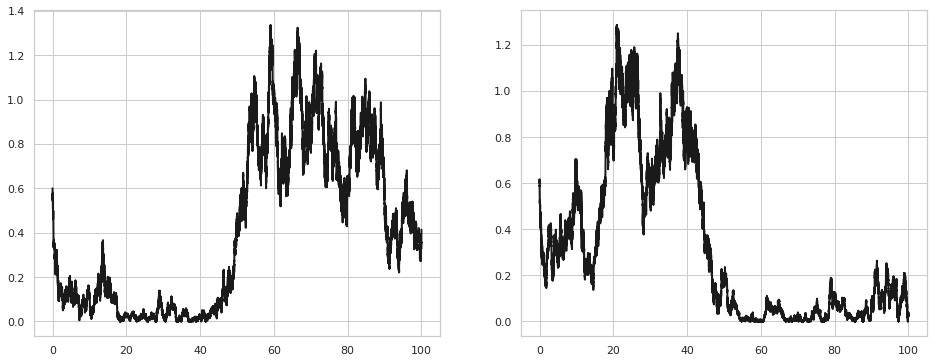

In [1339]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
ax0, ax1 = axes.flatten()
ax0.plot(t, em_traj[49,0,:], '-', lw=2, 
           color="k")
ax1.plot(t, em_traj[49,1,:], '-', lw=2, 
           color="k")

## (Plot) Attractor transition matrices as graph using networkx and pygraphviz


In [1312]:
e = np.sum(transition_mat, axis = 0)
normalised_transition_mat = np.round((e.T/e.sum(axis=1)).T , 2)
#ss_colors_new = ["#ED1C24", '#38b6ff', '#ff9400'] #Specifying the attractor colors


In [1002]:
G = nx.DiGraph(normalised_transition_mat)
for u,v,d in G.edges(data=True):
    d['label'] = d.get('weight','')
        
A = to_agraph(G)
A.layout(prog='dot')

for i, node in enumerate(A.iternodes()):
    node.attr['fillcolor'] = ss_colors_new[i]
    node.attr['style'] = "filled"
    
A.draw('plots_stochastic/Transition_matrices.png')

## (Plot) Mean first passage time

In [1323]:
attractor_names = ["0", "1", "2"]
mean_fpt = fpt.mean(axis = 0)

Text(0, 0.5, 'Mean first passage time')

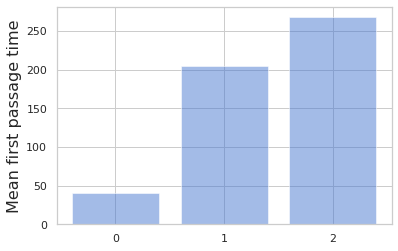

In [1325]:
plt.bar(attractor_names, mean_fpt, align='center', alpha=0.5)
#plt.xticks(ave_counts, attractor_names)
plt.ylabel('Mean first passage time')

## (Plot) Attractor entry counts as barchart

In [1187]:
ave_counts = np.sum(counts, axis = 0)/counts.shape[0]
x_init = y_init = 0.6


Text(0.5, 1.0, 'Attractor entry average counts with initial condition 0.6 , 0.6')

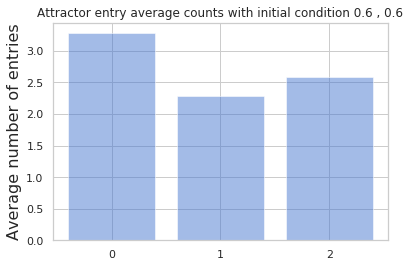

In [1244]:
attractor_indices
plt.bar(attractor_names, ave_counts, align='center', alpha=0.5)
#plt.xticks(ave_counts, attractor_names)
plt.ylabel('Average number of entries')
plt.title('Attractor entry average counts with initial condition {} , {}'. format(x_init, y_init))

## (Plot) Counting number of trajectories ending in respective attractors

[Text(0, 0, 'Transient'), Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')]

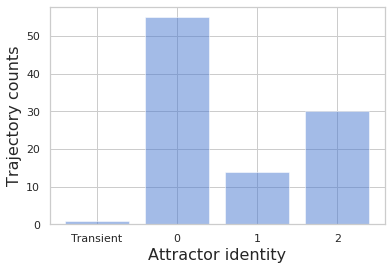

In [1293]:
from collections import Counter
attractor_count_dict = OrderedDict(sorted(Counter(final_attractors).items(), key=lambda t: t[0]))

fig, ax = plt.subplots()

ax.bar(attractor_count_dict.keys(), attractor_count_dict.values(), align='center', alpha=0.5)
plt.ylabel('Trajectory counts')
plt.xlabel('Attractor identity')
ax.xaxis.set_ticks(np.arange(-1, 3, 1))#ax.plot.xticks([-1,0,1,2])
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[0] = "None"
a = ax.get_xticks().tolist()
a[0] = "Transient"
ax.set_xticklabels(a)

## (Plot) Mean dwell time in attractors

In [1306]:
mean_dwell_times = np.array(mean_dwell).mean(axis = 0)
sd_dwell_times = np.array(mean_dwell).std(axis = 0)
print("Standard deviation across trajectories", sd_dwell_times)
print("Mean across trajectories", mean_dwell_times)


Standard deviation across trajectories [10740.17603298 11546.90236555  7018.35096549]
Mean across trajectories [17177.56983333 12811.31385714  7714.95560714]


Text(0, 0.5, 'Mean dwell time in each attractor')

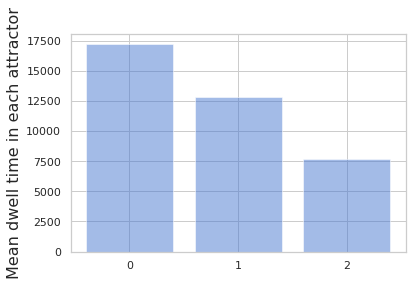

In [1307]:
plt.bar(attractor_names, mean_dwell_times, align='center', alpha=0.5)
plt.ylabel('Mean dwell time in each attractor')

## (Plot) individual trajectories on deterministic phase portrait

Here, I want to include the individual trajectories on the phase portrait.
On the phase portrait, i want to indicate:
1. The stable steady states, with a label indicating the attractor index: 0 for the middle, 1 for low x high y, 2 for low y high x
2. A circular region on the plot to indicate the attractor 'entry zone'.
3. Separatrices that carve out the respective basins.
4. For the anomalous trajectories, to highlight the transition between attractors 1 and 2 without entering the entry zone of attractor 0. Maybe sample more sparsely to avoid cluttering the plot. Also, color by time to show progression of trajectory on the phase portrait.


In [1018]:
# Anomalous transitions occur between attractors 1 and 2, without going through attractor 0 
mat_index = [i for i in range(transition_mat.shape[0]) if (transition_mat[i][1,2] != 0) or (transition_mat[i][2,1] !=0) ]

[0,
 2,
 3,
 10,
 11,
 29,
 30,
 31,
 33,
 34,
 42,
 44,
 49,
 50,
 68,
 70,
 73,
 83,
 86,
 91,
 92,
 94,
 95,
 96,
 98,
 99]

In [1005]:
import matplotlib.collections as mcoll

def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=None,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


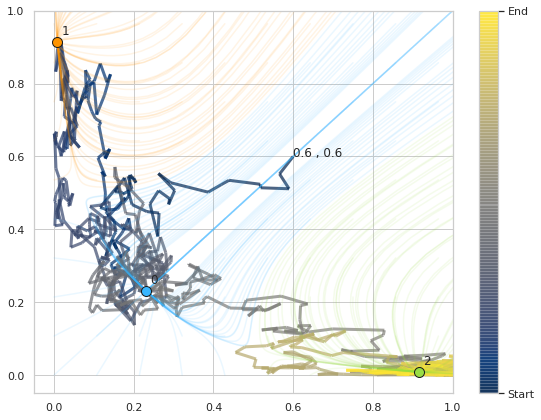

In [1321]:
start = 0
end = 50000
sample = 50

x = em_traj[mat_index[0]][0][start:end:sample] 
y = em_traj[mat_index[0]][1][start:end:sample]
fig, ax = plt.subplots(figsize = (8,6))

lc = colorline(x, y, cmap=plt.cm.cividis, alpha = 0.7)
cbar = plt.colorbar(lc, ticks=[0, 1])
cbar.ax.set_yticklabels(['Start', 'End'])

for j in range(num_paths):
    ax.plot(paths[1,j,:,0], paths[1,j,:,1], color=path_colors[1][j], alpha = 0.1) #Plotting the paths
#axis.plot(paths[2,j,0,0], paths[2,j,0,1], marker = '.', color=path_colors[2][j],  markersize=8) #Plotting the starting points of paths (dots on the fig)


for j in range(len(stable_steady_states)):
    ax.annotate('{}'.format(j), xy=(stable_steady_states[j][0][2], stable_steady_states[j][1][2]),  xycoords='data',
            xytext=(stable_steady_states[j][0][2] + 0.01, stable_steady_states[j][1][2] + 0.02))

    ax.plot(stable_steady_states[j][0][2],  stable_steady_states[j][1][2], marker ='o', ms = 10, mew =1, mec = 'k', mfc=ss_colors[j])

ax.annotate('{} , {}'.format(x_init, y_init), xy=(x_init, y_init),  xycoords='data',
            xytext=(x_init, y_init))
plt.xlim(-0.05, 1)
plt.ylim(-0.05, 1)
plt.tight_layout()
#fig.savefig('plots_stochastic/2_stoch_switching.png', bbox_inches='tight')


## Code for quiver plot

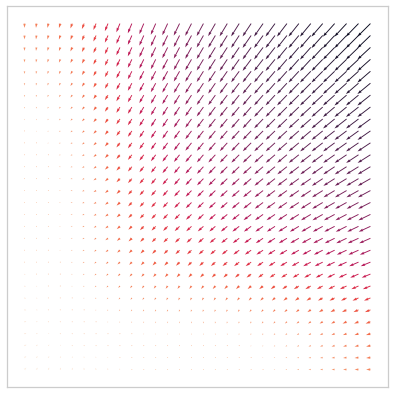

In [424]:
alpha1 = 0.25
alpha2 = 0.25
a = c = 0.6
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25

x = np.arange(0, 1.5, 0.05)
y = np.arange(0, 1.5, 0.05)

X, Y = np.meshgrid(x, y)
[dx,dy] = toggle_rhs([X,Y], alpha1, alpha2, a, c, b, d, lambda1, lambda2)
n = -2
color_array = np.sqrt(((dx-n)/2)**2 + ((dy-n)/2)**2)

fig, ax = plt.subplots(figsize=(7,7))
ax.quiver(X,Y,dx,dy,color_array)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')

plt.show()


In [391]:
test[mat_index[0]][0][0:10:2]

array([0.6       , 0.60035524, 0.61085189, 0.6145389 , 0.61053025])

2000

In [225]:
stable_steady_states[0][0][2]

0.197540380851236

In [475]:
%reload_ext line_profiler
%lprun -T lp_results_switch.txt -f switch_number switch_number(test, 0.1, 0.1, 0.2, 0.2, stable_steady_states)
%cat lp_results_switch.txt


*** Profile printout saved to text file 'lp_results_switch.txt'. 
Timer unit: 1e-06 s

Total time: 19.8133 s
File: <ipython-input-468-78a99b0ee051>
Function: switch_number at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def switch_number(traj_matrix, dist_entry_x, dist_entry_y, dist_exit_x, dist_exit_y, attractors_coord):
     2         1          5.0      5.0      0.0      all_times = []
     3         6         15.0      2.5      0.0      for traj in range(traj_matrix.shape[0]):
     4         5     235390.0  47078.0      1.2          paired_coord = np.array(list(zip(traj_matrix[traj,0,:], traj_matrix[traj,1,:]))) 
     5         5         12.0      2.4      0.0          times = []
     6        20         33.0      1.6      0.0          for index in range(len(attractors_coord)):
     7                                                       #print ("entering attractor", index)
     8        15          8.0    

# Acknowledgements

[Gillespie code](https://github.com/aristoteleo/dynamo-release/blob/master/dynamo/simulation/gillespie_utils.py) 

Algorithm for gillespie simulation plots adapted from Xiaojie Qiu and Yan Zhang

[Gillespie plots](http://be150.caltech.edu/2019/handouts/12_stochastic_simulation.html)

 Plotting of gillespie simulation plots and method to speed up the algorithm was adapted from Justin Bois's jupyter notebook


# Dependencies

In [214]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,scipy,watermark,networkx,pygraphviz

print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.8.2
IPython 7.13.0

numpy 1.18.1
matplotlib 3.1.3
seaborn 0.10.0
scipy 1.4.1
watermark 2.0.2
networkx 2.4
pygraphviz 1.5

compiler   : GCC 7.3.0
system     : Linux
release    : 4.18.0-25-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit
 
last updated: Fri May 22 2020 13:25:08 BST


# Miscellaneous Notes

In [ ]:
def flatten(container):
    """Helper generator that returns completely flattened list"""
    for i in container:
        if isinstance(i, (list,np.ndarray)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [ ]:
def switch_stats(switch_times):
    entry_times_tot, attractor_indices_tot = ([] for _ in range(2))
    if switch_times.ndim > 1: 
        #print("Trajectory_times list is of dimension 1 == only 1 trajectory is given")
        for trajectory_times in switch_times: 
            entry_times, attractor_indices = ([] for _ in range(2))
            for attractor_index in range(len(trajectory_times)):
                if isinstance(trajectory_times[attractor_index].squeeze()[0], numbers.Integral) and trajectory_times[attractor_index].squeeze()[0] != 0 :
                    entry_times.append(trajectory_times[attractor_index].squeeze()[0])
                    attractor_indices.append(attractor_index)
                elif isinstance(trajectory_times[attractor_index].squeeze()[0], (list,np.ndarray)):
                    for attractor_time in trajectory_times[attractor_index].squeeze():
                        if attractor_time[0] != 0 :
                            entry_times.append(attractor_time[0])
                            attractor_indices.append(attractor_index)
            zipped_pairs = list(zip(entry_times, attractor_indices))
            sorted_attractor_indices = [x for _,x in sorted(zipped_pairs)]
            sorted_entry_times = sorted(entry_times)
            entry_times_tot.append(sorted_entry_times)
            attractor_indices_tot.append(sorted_attractor_indices)
        
        attractor_transition_mat = np.zeros((switching.shape[0], len(stable_steady_states),len(stable_steady_states)), dtype = np.int16)
        attractor_counts = np.zeros((switching.shape[0], len(stable_steady_states)), dtype = np.int16)
    
        for n_traj in range(switching.shape[0]):
            y = list(zip(entry_times_tot[n_traj],attractor_indices_tot[n_traj]))
            print("before ordereddict", y)

            ## Removing duplicates
            y = list(OrderedDict.fromkeys(y))
            #print("after ordereddict", y)

            ## Removing zero entry times as they do not contribute to our transition matrix or the counts
            i = 0
            while i < len(y):
                element = y[i]
                if element[0] == 0:
                    y.remove(element)
                else:
                    i+=1
            print("after removing zero entries", y)

            ## Counting number of times system enters each attractor
            for l in y:
                print(l)
                attractor_counts[n_traj,l[1]] += 1

            print("attractor_counts", attractor_counts)

            ## Creating the attractor_transition_matrix
            j = 0
            while j < len(y)-1:
                #print("In while loop", y[j][1])
                attractor_transition_mat[n_traj,(y[j])[1],(y[j+1])[1]] += 1
                j+=1

            print("attractor_transition_mat",attractor_transition_mat)

    else: #So we can also extract entry times for single trajectories (otherwise only collections allowed)
        trajectory_times = switch_times
        for attractor_index in range(len(trajectory_times)):
            if isinstance(trajectory_times[attractor_index].squeeze()[0], numbers.Integral):
                entry_times_tot.append(trajectory_times[attractor_index].squeeze()[0])
                attractor_indices_tot.append(attractor_index)
            elif isinstance(trajectory_times[attractor_index].squeeze()[0], (list,np.ndarray)):
                for attractor_time in trajectory_times[attractor_index].squeeze():
                    entry_times_tot.append(attractor_time[0])
                    attractor_indices_tot.append(attractor_index)      
        zipped_pairs = list(zip(entry_times_tot, attractor_indices_tot))
        attractor_indices_tot = [x for _,x in sorted(zipped_pairs)]
        entry_times_tot = sorted(entry_times_tot)
        
        attractor_transition_mat = np.zeros((len(stable_steady_states),len(stable_steady_states)), dtype = np.int16)
        attractor_counts = np.zeros(len(stable_steady_states), dtype = np.int16)

        y = list(zip(entry_times_tot,attractor_indices_tot))
        print("before ordereddict", y)

        ## Removing duplicates
        y = list(OrderedDict.fromkeys(y))
        print("after ordereddict", y)

        ## Removing zero entry times as they do not contribute to our transition matrix or the counts
        i = 0
        while i < len(y):
            element = y[i]
            if element[0] == 0:
                y.remove(element)
            else:
                i+=1
        print("after removing zero entries", y)

        ## Counting number of times system enters each attractor
        for l in y:
            attractor_counts[l[1]] += 1

        print("attractor_counts", attractor_counts)

        ## Creating the attractor_transition_matrix
        j = 0
        while j < len(y)-1:
            #print("In while loop", y[j][1])
            attractor_transition_mat[(y[j])[1],(y[j+1])[1]] += 1
            j+=1

        #print("attractor_transition_mat",attractor_transition_mat)

    return (entry_times_tot, attractor_indices_tot, attractor_transition_mat, attractor_counts)
    
           
#list(flatten([item[0] for item in switching[2]]))

#[item[0] if item.shape[0] == 1 else item.f for item in np.flatten(switching[2])]
#list(zip(*switching[2]))[0]

In [42]:
x = 0
y = 1
n_species= 2

# stoichiometry matrix
stoich = np.zeros((4, n_species))
stoich[0, x] = 1  # null -> x
stoich[1, x] = -1  # x -> null
stoich[2, y] = 1  # null -> y
stoich[3, y] = -1  # y -> null

# Update function: take concentration vector and update it by adding corresponding stoichometric reaction row.
update_func = lambda X, mu: X + stoich[mu, :]
t_span = [0,5]
X0 = np.array([700,200])

%reload_ext line_profiler
%lprun -T lp_results.txt -f directMethod directMethod(\
lambda X: prop_hill(X, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega),\
update_func,t_span,X0)

%cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.151339 s
File: <ipython-input-37-a0d099a68280>
Function: directMethod at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def directMethod(
     2                                               prop_fcn, update_fcn, tspan, X0, record_skip_steps=0, record_max_length=1e5
     3                                           ):
     4                                               # Initialise array to hold the concentration and time values, with the appropriate dimensions.
     5         1         96.0     96.0      0.1      retX = np.zeros((len(X0), int(record_max_length)), np.float64)
     6         1         48.0     48.0      0.0      retT = np.zeros(int(record_max_length), np.float64)
     7                                               
     8                                               # Initialise initial concentration an

In [60]:
X = np.array([700,200])
omega = 1000
alpha1 = 0.1 * omega
alpha2 = 0.1 * omega
a =0.5 * omega
c = 0.5 * omega
b = 0.4 * omega
d = 0.4 * omega
max1 = 1 * omega
max2 = 1 * omega
lambda1 = 1.25 * omega
lambda2 = 1.25 * omega
print('Old propensity function:')
%timeit prop_hill(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega)

print('Numba propensity function:')

%timeit prop_hill_numba(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega)

Old propensity function:
44.7 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Numba propensity function:


<ipython-input-59-205c9e7c38bc>:59: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "prop_hill_numba" failed type inference due to: Untyped global name 'protein_production': cannot determine Numba type of <class 'function'>

File "<ipython-input-59-205c9e7c38bc>", line 67:
def prop_hill_numba(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega):
    <source elided>
    prop = np.zeros(4)
    prop[0],prop[2] = omega * protein_production (X, alpha1, alpha2, a, c, b, d, max1, max2, tolerance = 1e-8)
    ^

  @numba.jit()
/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/numba/object_mode_passes.py:177: NumbaWarning: Function "prop_hill_numba" was compiled in object mode without forceobj=True.

File "<ipython-input-59-205c9e7c38bc>", line 60:
@numba.jit()
def prop_hill_numba(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/po

51.2 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
print('Old direct mtd:')
%timeit directMethod(\
lambda X: prop_hill(X, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega),\
update_func,t_span,X0)

print('New direct mtd:')
%timeit directMethod_numba(\
lambda X: prop_hill(X, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega),\
update_func,t_span,X0)

Old direct mtd:
4.66 s ± 750 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
New direct mtd:


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'sum': cannot determine Numba type of <class 'builtin_function_or_method'>

File "<ipython-input-62-bf67c6b7a091>", line 20:
def directMethod_numba(
    <source elided>
        a = prop_fcn(X)
        a0 = sum(a)
        ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'function'>
- argument 1: cannot determine Numba type of <class 'function'>


In [ ]:
def protein_production_non_dim (x, A1, A2, alpha1, alpha2, R1, R2, tolerance = 1e-8): 
    """Same function as the protein_production definition above, but non-dimensionalised. """
    
    xp,yp = x[0],x[1]
    xdot = A1*(alpha1 + (xp**4 / (1+xp**4 )))*(R1**4/ (R1**4 +yp**4))
    ydot = A2*(alpha2 + (yp**4 / (1+yp**4 )))*(R2**4/ (R2**4 + xp**4)) 
    f = np.array([xdot, ydot])
    
    for conc in f:
        if conc < tolerance:
            conc = 0
    return f

In [187]:
def decay_non_dim (x, D, tolerance = 1e-8):
    """Same function as the protein_production definition above, but non-dimensionalised

    
    Keyword arguments:
    lambda1-- decay rate of protein product X.
    lambda2-- decay rate of protein product Y. """
    
    xd,yd = x[0],x[1]
    xdot = xd
    ydot = D*yd
    f = np.array([xdot, ydot])
   
    for conc in f:
        if conc < tolerance:
            conc = 0
        
    return f
    

In [180]:
# Vector containing successive values of the trajectory for both genes
x = np.zeros((2,n))

# Initial condition 
x[:,0]= [0.2,0.2]

tolerance = 1e-8

# Euler-Marayama method
for i in range(n - 1):
    pp = protein_production_non_dim([x[0][i], x[1][i]],A1,A2,alpha1,alpha2,R1,R2)
    de = decay_non_dim([x[0][i], x[1][i]],D)
    detT = deterministic_term(pp,de)
    stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
    x[0][i + 1] = x[0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
    x[1][i + 1] = x[1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()
    
    # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
    if(x[0][i + 1] < tolerance):
        x[0][i + 1] = 0
    elif(x[1][i + 1] < tolerance):
        x[1][i + 1] = 0


In [181]:
#Interpolating values
k = 10


""" Arguments for numpy.interpolate:
1) All x_vals to do interpolation on 
2) Actual x_val values that u feed into function x 
3) The function f(x)"""

x_interpolate = np.interp(np.arange(n * k), np.arange(n) * k, x[0]) 
y_interpolate = np.interp(np.arange(n * k), np.arange(n) * k, x[1])

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
ax0, ax1, ax2 = axes.flatten()

ax0.plot(t,x[0]
        )
ax0.set_title("Sample path of gene X")
ax1.plot(t,x[1])
ax1.set_title("Sample path of gene Y")
ax2.scatter(x_interpolate, y_interpolate, c = range(n * k), cmap=plt.cm.jet, linewidths=0, marker='o', s=3)
ax2.set_title("Phase portrait of X and Y with simulated trajectory")


Text(0.5, 1.0, 'Phase portrait of X and Y with simulated trajectory')

Error in callback <function flush_figures at 0x7fbe38807dc0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
def multiplicative_noise (protein_production, decay, dt, omega):
    """Return the multiplicative noise term of the chemical langevin equation (CLE).
    
    Keyword arguments:
    omega -- Volume parameter relates concentrations to the number of molecules as such:
    (number of molecules = omega * concentration)
    
    Derive the stochastic_term variable by examining the variance of the diffusion approximation of the
    immigration-death process, which is simply the expectation of X^2. """
    
    white_noise = np.random.randn(2)
    #white_noise = [u,v for u,v in zip(white_noise_X, white_noise_Y)]
    sqrtdt =  np.sqrt(dt / omega) 
    stochastic_term = np.array([np.sqrt(protein_production[0] + decay[0]), np.sqrt(protein_production[1] + decay[1])])
    f = stochastic_term * sqrtdt * white_noise
    
    return f

In [ ]:
def additive_noise (constant_noise, dt, omega):
    """Return the additive noise term of the langevin equation.
    
    Keyword arguments:
    constant_noise -- State-independent, constant noise term. """
    
    white_noise = np.random.randn(2)
    sqrtdt =  np.sqrt(dt / omega) 
    f = constant_noise * sqrtdt * white_noise
    
    return f



In [ ]:
def chemical_langevin_equation(deterministic_term, multiplicative_noise):
    """Return the chemical langevin equation (CLE).
    
    Write as sum of the deterministic term and the multiplicative noise term"""
    
    xdet,ydet, xmnoise, ymnoise = deterministic_term[0], deterministic_term[1], multiplicative_noise[0], multiplicative_noise[1]
    xdot = xdet + xmnoise
    ydot = ydet + ymnoise
    f = np.array([xdot, ydot])
    
    return f


In [ ]:
def langevin_equation(deterministic_term, additive_noise):
    """Return the langevin equation.
    
    Write as sum of the deterministic term and the additive noise term"""
    
    xdet,ydet, xanoise, yanoise = deterministic_term[0], deterministic_term[1], additive_noise[0], additive_noise[1]
    xdot = xdet + xanoise
    ydot = ydet + yanoise
    f = np.array([xdot, ydot])
    
    return f

## Testing functions

In [ ]:
x0 = [0.1, 0.1]
alpha1 = 0.25
alpha2 = 0.25
a = 0.25
c = 0.25
b = 0.4
d = 0.4
lambda1 = 0.25
lambda2 = 0.25
dt = 0.001
omega = 10
constant_noise = 0.10

In [ ]:
pp = protein_production(x0,alpha1,alpha2,a,c,b,d)
de = decay(x0,lambda1,lambda2)
detT = deterministic_term(pp,de)
mn = multiplicative_noise(pp,de,dt,omega)
an = additive_noise(constant_noise,dt,omega)
cle = chemical_langevin_equation(detT, mn)
le = langevin_equation(detT, an)


#print(pp, de, detT, mn, an, cle, le, sep="\n")

In [ ]:
dt = 0.00001
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

x = np.zeros((2,n))

for i in range(n-1):
    for j in range(2):
        x[j][i+1] = x[j][i] + chemical_langevin_equation(detT, multiplicative_noise(pp,de,dt,omega))[j]

In [ ]:
print(mn)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x[1], lw=2)

In [ ]:
x = np.zeros((2,n))
x